In [1]:
# Import libraries

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from scipy.fft import fft, fftfreq
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes
import imufusion
import sys
from tqdm import tqdm
from scipy.signal import firwin
from ipywidgets import IntSlider, interact
from IPython.display import clear_output

In [2]:
### Functions ###

def freq_axis(fdata):
    xf = fftfreq(len(fdata), fs)[:len(fdata)//2]
    xf = np.linspace(0,fs/2,int(np.floor(len(fdata/2)+1)))
    return xf


def butter_bandpass(lowcut_hr, highcut_hr, fs, order=4):
        nyq = 0.5 * fs
        low = lowcut_hr / nyq
        high = highcut_hr / nyq
        sos = signal.butter(order, [low, high], btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, name, lowcut_hr, highcut_hr, fs, order=4, plot=False):
        sos = butter_bandpass(lowcut_hr, highcut_hr, fs, order=order)
        y = signal.sosfiltfilt(sos, data)

        ## TODO: Plot a graph of freq domain data
        xhz = freq_axis(data)
        # print('Hello xhz', xhz, '\nxhz shape', xhz.shape)
        yhz = 2*np.abs(fftpack.fft(y))

        if plot:
        # print('Hello yhz', yhz.shape, 'and', yhz.size)
            plt.plot(xhz[:len(yhz)],yhz[:len(yhz)])
            plt.title(f'FFT Plot {name} (post bandpass filter)')
            plt.xlabel('Frequency (Hz)'), plt.ylabel('Amplitude (AU)')
            plt.grid(True),plt.tick_params(axis='both', which='major', labelsize='small')
        
        # plt.savefig(f'fftpostbandpass{name}_{todaysdate}.svg')
        # plt.clf()
        return y


### Extrapolate time functions ###
def extrapolate_time(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds.
    """
    # ensure Time is a datetime64 dtype
    data = data.copy()
    data['Time'] = pd.to_datetime(data['Time'])

    n = len(data)
    start = data['Time'].iloc[0]

    # pandas Timedelta for one sample interval
    interval = pd.to_timedelta(1 / sampling_frequency, unit='s')

    # build an evenly spaced index
    return pd.date_range(start=start, periods=n, freq=interval)

def extrapolate_time2(data, sampling_frequency):
    """
    Given a DataFrame `data` with a DateTime column 'Time', 
    return a DatetimeIndex of the same length as `data`,
    starting at the first timestamp and spaced by 1/sampling_frequency seconds
    for every interval of repeated timestamps.
    """
    # ensure Time is a datetime64 dtype
    times = data['Time']
    slot = data.groupby('Time').cumcount()
    dt = pd.to_timedelta(1 / sampling_frequency, unit='s')
    new_times = times + slot * dt
    return pd.DatetimeIndex(new_times)

In [3]:
### Parameters

fs = 104 # sampling frequency


In [4]:
### Set up Data Frame ###

# ### 2024
# study_time_str = '09192024 09:36:57.026'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed09192024\modified_processed09192024.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   parse_dates=['Time'],
#   dtype={
#     'XL_X': float, 'XL_Y': float, 'XL_Z': float,
#     'G_X': float,  'G_Y': 
# float,  'G_Z': float,
#     'Temperature': float, 'Voltage': float, 'Packet': int
#   },
#     delimiter = ',',
# )
# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage', 'Packet'])
# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

##############

### Jan 2025
# study_time_str = '01162025 09:18:38.444'
# study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
# file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Data\processed011620252\01162025_imuprocessed.csv"

# header = 0
# data = pd.read_csv(
#   file, header = header,
#   dtype={
#     'Time': str, 'XL_X': str, 'XL_Y': str, 'XL_Z': str,
#     'G_X': str,  'G_Y': str,  'G_Z': str,
#     'Temperature': str, 'Voltage': str, 'Packet': int
#   },
#     delimiter = ',',
# )

# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z',
#     'Temperature', 'Voltage','Packet'])

# df = df[~df.eq('N').any(axis=1)].copy()

# cols = ['XL_X','XL_Y','XL_Z',
#         'G_X','G_Y','G_Z',
#         'Temperature','Voltage','Packet']
# df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')



##########

### July 2025
study_time_str = '07022025 08:35:26.300'
study_time = pd.to_datetime(study_time_str, format='%m%d%Y %H:%M:%S.%f')
file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\processed07022025\07022025_imuprocessed.csv"

header = 0
data = pd.read_csv(
  file, header = header,
  parse_dates=['Time'],
  dtype={
    'XL_X': str, 'XL_Y': str, 'XL_Z': str,
    'G_X': str,  'G_Y': str,  'G_Z': str,
    'Temperature': str, 'Voltage': str, 'Packet': int
  },
    delimiter = ',',
)
df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
    'G_X',  'G_Y',  'G_Z',
    'Temperature', 'Voltage', 'Packet'])

cols = ['XL_X','XL_Y','XL_Z',
        'G_X','G_Y','G_Z',
        'Temperature','Voltage','Packet']
df.dropna(axis=0, how='any', inplace=True)
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

# # df


# csv_path = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Data Collection\Data\processed\07102025\r.csv"


# header = 0
# data = pd.read_csv(
#   csv_path, header = header,
#   dtype={
#     'Time': str, 'XL_X': float, 'XL_Y': float, 'XL_Z': float,
#     'G_X': float,  'G_Y': float,  'G_Z': float,
#     'Temperature': float, 'Voltage': float, 'Packet': int
#   },
#     delimiter = ',',
# )
# # print(data)

# study_time_str = data.iloc[0,0]
# study_time = pd.to_datetime(study_time_str, format='%Y-%m-%d %H:%M:%S.%f')

# df = pd.DataFrame(data, columns=["Time", 'XL_X', 'XL_Y', 'XL_Z',
#     'G_X',  'G_Y',  'G_Z'])
# df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [5]:
### Extrapolate times ###
new_times = extrapolate_time(df, sampling_frequency=104)
df['Time'] = new_times
delta = df['Time'] - study_time
df['Seconds'] = delta.dt.total_seconds()
df['Seconds'] = pd.to_numeric(df['Seconds'], errors="coerce")

In [6]:
global_interval = [1500,1560]

(-200.0, 200.0)

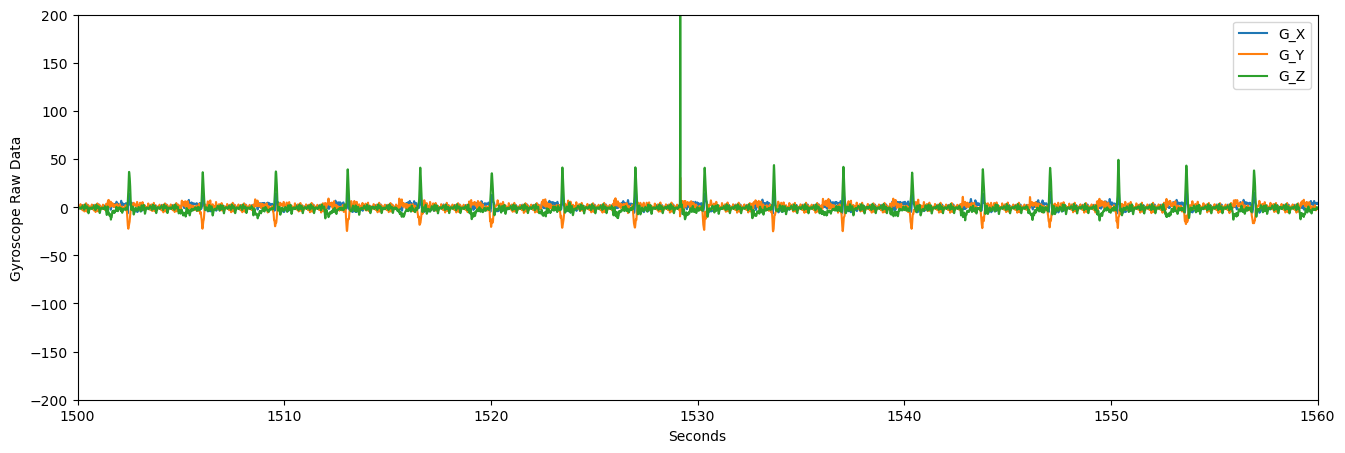

In [7]:
### Viusalize data
df.plot(x='Seconds', y = ['G_X',  'G_Y',  'G_Z'], figsize=(16,5))
plt.ylabel('Gyroscope Raw Data')
plt.xlim(global_interval)
plt.ylim(-200,200)

In [8]:
### Only use data starting at certain point after visualizing raw data###
new_start = 1500 #seconds
cropped_df = df[df['Seconds'] >new_start].copy()
cropped_df = cropped_df.set_index('Time', drop=False)
# cropped_df

# cropped_df.plot(x='Seconds', y = ['G_X',  'G_Y',  'G_Z'], figsize=(16,5))
# plt.ylabel('Cropped Raw Data')
# cropped_df.plot(x='Seconds', y = ['G_X',  'G_Y',  'G_Z'], figsize=(16,5))
# plt.ylabel('Cropped Raw Data')

In [9]:
## Convert unit of angulat velocity from mdps to dps (Why?)

cropped_df["G_X_dps"] = cropped_df["G_X"]/1000 
cropped_df["G_Y_dps"] = cropped_df["G_Y"]/1000
cropped_df["G_Z_dps"] = cropped_df["G_Z"]/1000

# cropped_df

In [10]:
# Calculate Euler angles
cropped_df_accel = cropped_df[['XL_X','XL_Y','XL_Z']].to_numpy()
cropped_df_gyro = cropped_df[['G_X_dps','G_Y_dps','G_Z_dps']].to_numpy()


# Process reference data with fusion (https://github.com/xioTechnologies/Fusion)
dat_ahrs = imufusion.Ahrs()
dat_euler = np.empty((len(cropped_df["Time"]), 3))

for index in range(len(cropped_df["Time"])):
    dat_ahrs.update_no_magnetometer(cropped_df_gyro[index], cropped_df_accel[index], 1 / 104)  # 104 Hz sample rate
    dat_euler[index] = dat_ahrs.quaternion.to_euler() # in degrees
    
# Why do we need to use this? Why discont =30?
cropped_df['unwrapped_roll'] = np.unwrap(dat_euler[:,0], discont=30, period=360).tolist()
cropped_df['unwrapped_pitch'] = np.unwrap(dat_euler[:,1], discont=30, period=360).tolist()
cropped_df['unwrapped_yaw'] = np.unwrap(dat_euler[:,2], discont=30, period=360).tolist()

cropped_df['wrapped_roll'] = dat_euler[:,0]
cropped_df['wrapped_pitch'] = dat_euler[:,1]
cropped_df['wrapped_yaw'] = dat_euler[:,2]

# print(cropped_df)

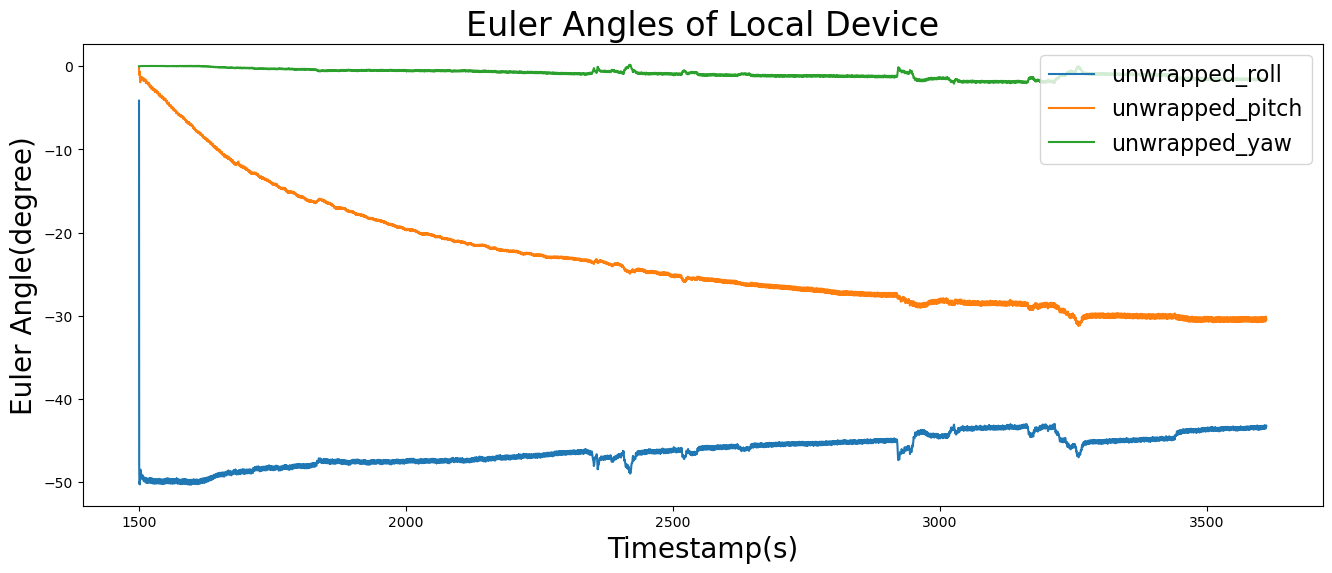

In [11]:
data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_roll", "unwrapped_pitch", "unwrapped_yaw"])
data_plot_G.plot(x="Seconds", y=["unwrapped_roll", "unwrapped_pitch", "unwrapped_yaw"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Euler Angle(degree)', fontsize="20")
plt.title("Euler Angles of Local Device", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
# plt.xlim(0,2000)
# plt.ylim(-1800,1600)
# plt.xlim(global_interval)
# plt.ylim(-500,1500)
# plt.xlim(1550,1600)
plt.show()

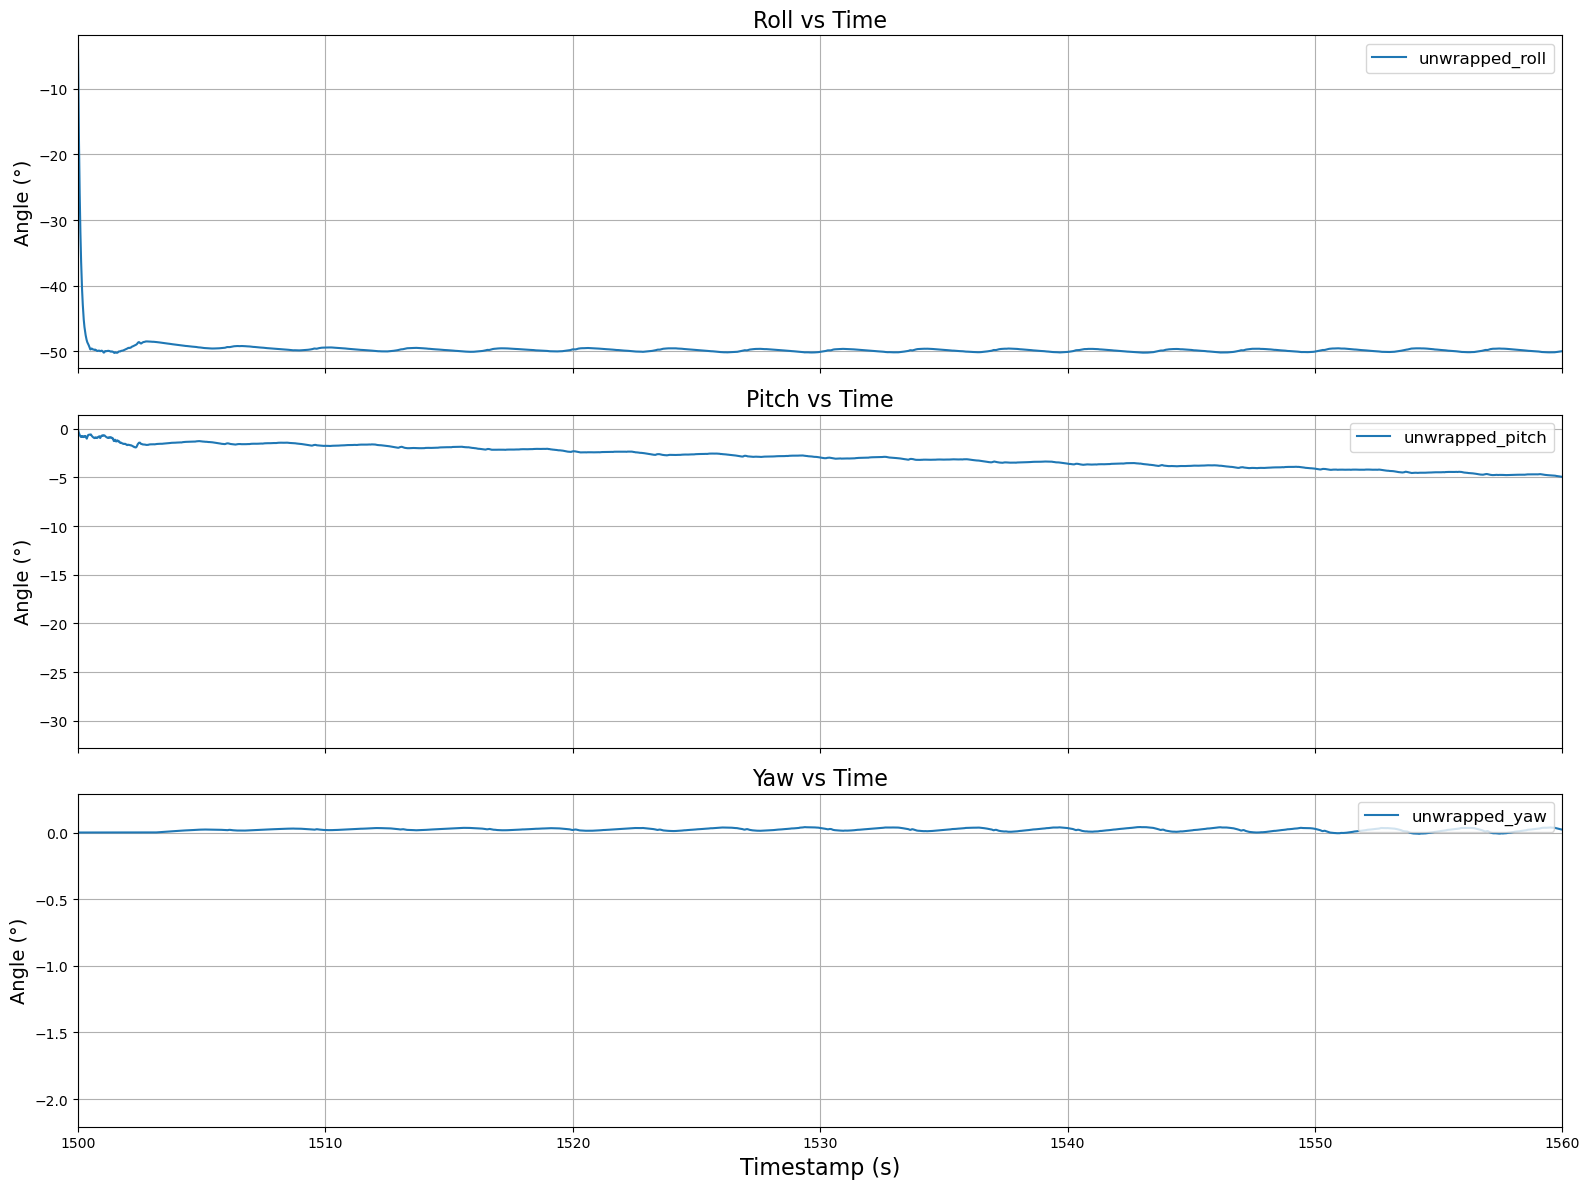

In [12]:
axes = ["unwrapped_roll", "unwrapped_pitch", "unwrapped_yaw"]
titles = ["Roll", "Pitch", "Yaw"]

# Create subplots
fig, axs = plt.subplots(len(axes), 1, figsize=(16, 12), sharex=True)

for i, axis in enumerate(axes):
    axs[i].plot(cropped_df["Seconds"], cropped_df[axis], label=axis)
    axs[i].set_ylabel("Angle (°)", fontsize=14)
    axs[i].set_title(f"{titles[i]} vs Time", fontsize=16)
    axs[i].legend(loc="upper right", fontsize=12)
    axs[i].grid(True)
    axs[i].set_xlim(1500, 1560)

# Shared X-axis label
plt.xlabel("Timestamp (s)", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [13]:
from scipy.signal import spectrogram

In [14]:
from glob import glob
from glob import os

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

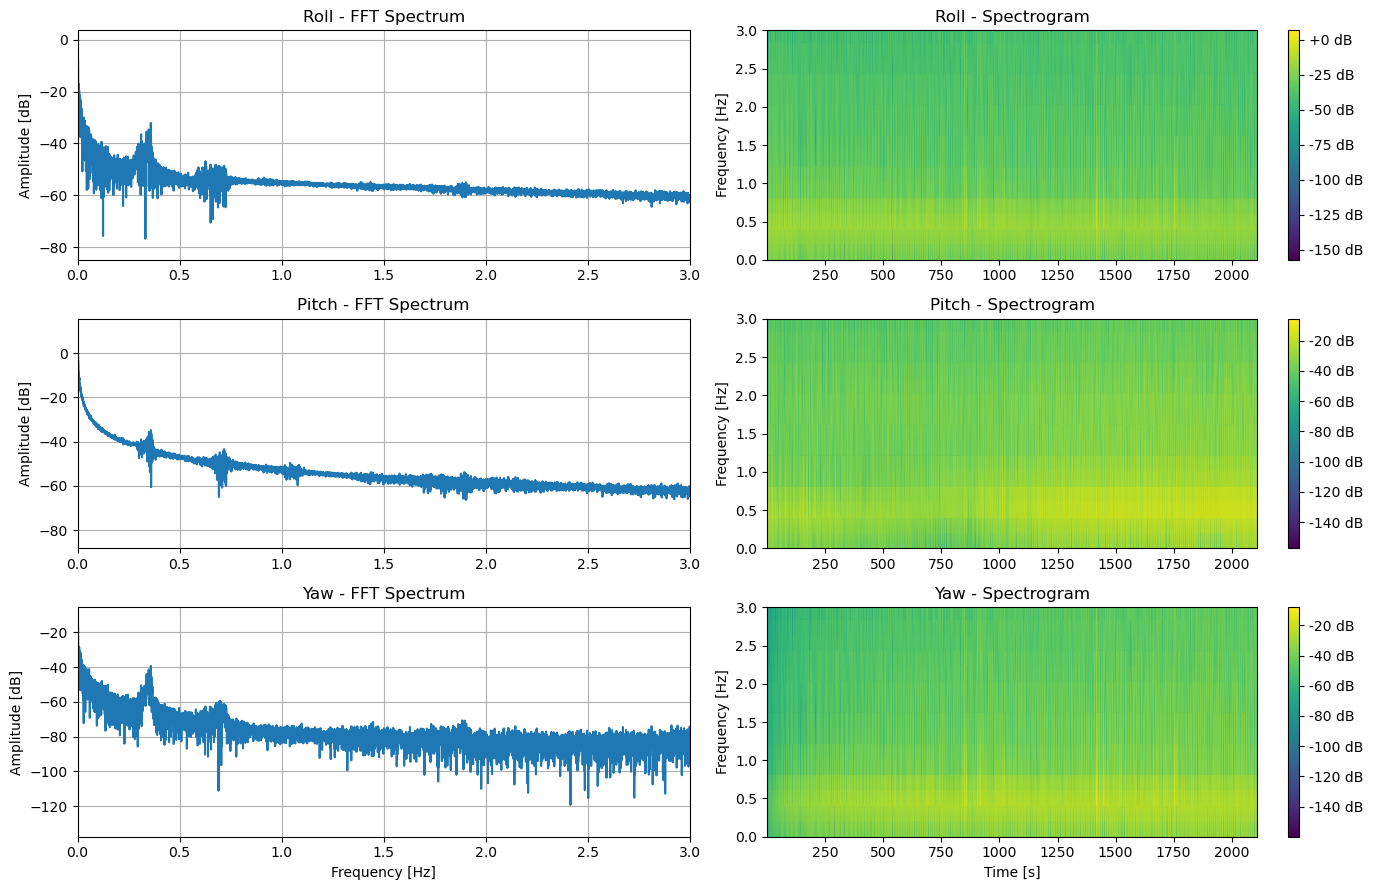

In [15]:

fs = 104  # sampling rate
N = len(cropped_df)
spacing = 1 / fs
freqs = fftfreq(N, spacing)
mask = freqs > 0

signal_keys = ['unwrapped_roll', 'unwrapped_pitch', 'unwrapped_yaw']
angle_labels = ['Roll', 'Pitch', 'Yaw']

fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows, 2 columns (FFT | Spectrogram)

for i, (col, label) in enumerate(zip(signal_keys, angle_labels)):
    my_signal = cropped_df[col].to_numpy(dtype=float)

    # --- FFT Amplitude Spectrum ---
    X = fft(my_signal)
    mag = np.abs(X[mask]) / N
    mag_db = 20 * np.log10(mag + 1e-16)
    axes[i, 0].plot(freqs[mask], mag_db, color='tab:blue')
    axes[i, 0].set_xlim(0, 3)
    axes[i, 0].set_ylabel('Amplitude [dB]')
    axes[i, 0].set_title(f'{label} - FFT Spectrum')
    axes[i, 0].grid(True)

    # --- Spectrogram ---
    f, t, Sxx = spectrogram(my_signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_db = 10 * np.log10(Sxx + 1e-16)
    im = axes[i, 1].pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='viridis')
    axes[i, 1].set_ylim(0, 3)
    axes[i, 1].set_title(f'{label} - Spectrogram')
    axes[i, 1].set_ylabel('Frequency [Hz]')
    fig.colorbar(im, ax=axes[i, 1], format='%+2.0f dB')

# Set common x-labels
axes[-1, 0].set_xlabel('Frequency [Hz]')
axes[-1, 1].set_xlabel('Time [s]')

plt.tight_layout()
plt.show()

In [16]:
# Butterworth non-causal zero phase lag bandpass filter

# # From image about Pig Vitals under anesthesia
# lowcut_hr = 1 # heart rate lower bound for bandpass filtering
# highcut_hr = 2 # heart rate upper bound for bandpass filtering
# lowcut_rr = 0.33 # respiratory rate lower bound for bandpass filtering
# highcut_rr = 0.66 # respiratory rate upper bound for bandpass filtering


# From image about Pig Vitals under anesthesia
lowcut_hr = 1 # heart rate lower bound for bandpass filtering
highcut_hr = 2 # heart rate upper bound for bandpass filtering
lowcut_rr = 0.25 # respiratory rate lower bound for bandpass filtering
highcut_rr = 0.6 # respiratory rate upper bound for bandpass filtering


for a_hr, a_rr, xl in zip(['unwrapped_r_hr', 'unwrapped_p_hr', 'unwrapped_y_hr'],['unwrapped_r_rr', 'unwrapped_p_rr', 'unwrapped_y_rr'], ['unwrapped_roll',  'unwrapped_pitch',  'unwrapped_yaw']):
    # fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    cropped_df[a_hr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_hr, highcut_hr, fs, order=4)
    cropped_df[a_rr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_rr, highcut_rr, fs, order=4)
    # plt.legend(['a_hr', 'a_rr'])


# # Neglect yaw
# for a_hr, a_rr, xl in zip(['unwrapped_r_hr', 'unwrapped_p_hr'],['unwrapped_r_rr', 'unwrapped_p_rr'], ['unwrapped_roll',  'unwrapped_pitch']):
#     # fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
#     cropped_df[a_hr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_hr, highcut_hr, fs, order=4)
#     cropped_df[a_rr] = butter_bandpass_filter(cropped_df[xl], xl, lowcut_rr, highcut_rr, fs, order=4)
#     # plt.legend(['a_hr', 'a_rr'])


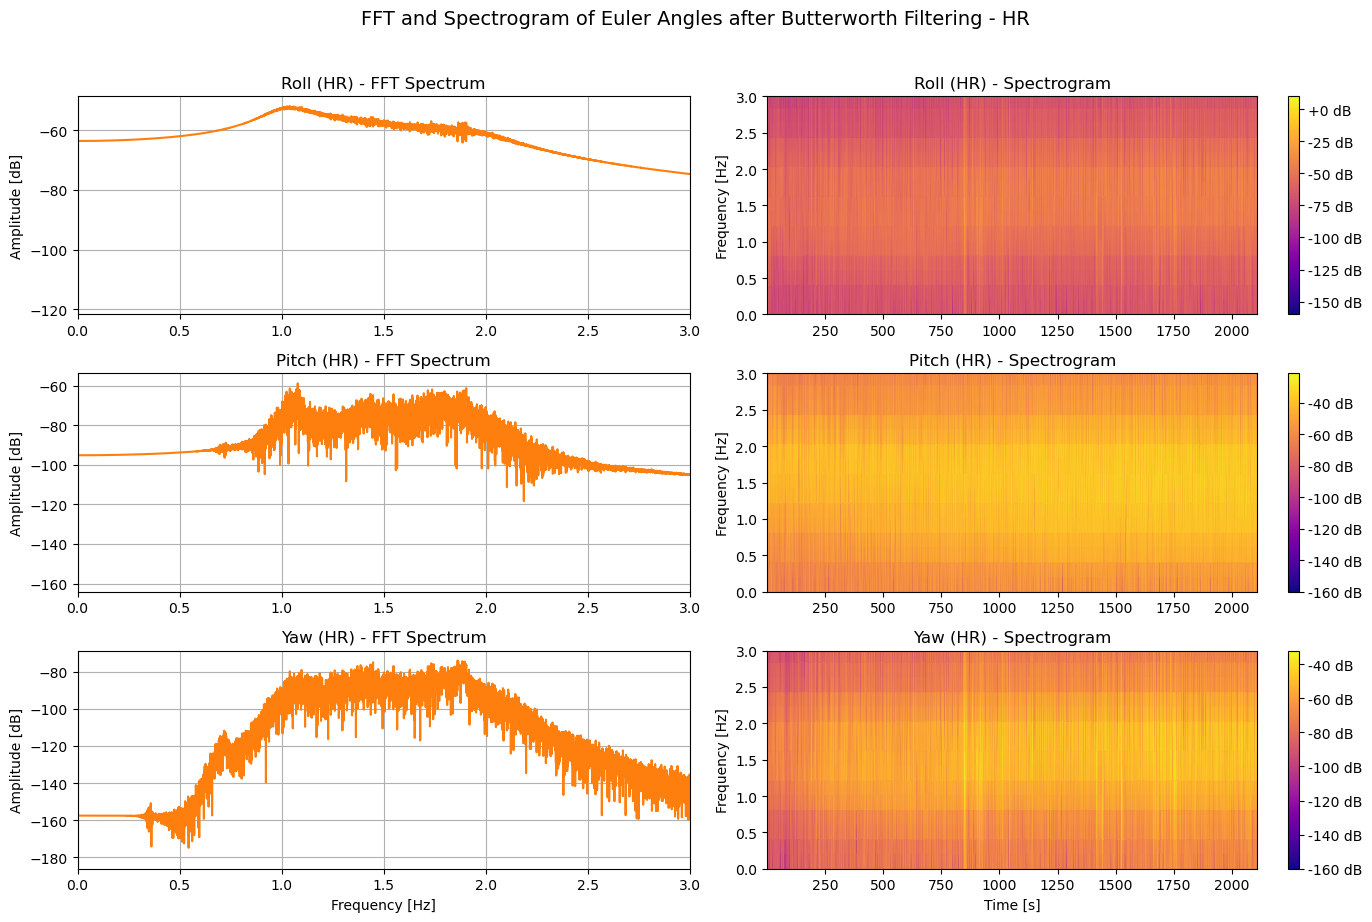

In [17]:
fs = 104  # sampling frequency
N = len(cropped_df)
spacing = 1 / fs
freqs = fftfreq(N, spacing)
mask = freqs > 0

signal_keys = ['unwrapped_r_hr', 'unwrapped_p_hr', 'unwrapped_y_hr']
angle_labels = ['Roll (HR)', 'Pitch (HR)', 'Yaw (HR)']

fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows: Roll, Pitch, Yaw; 2 columns: FFT | Spectrogram

for i, (col, label) in enumerate(zip(signal_keys, angle_labels)):
    my_signal = cropped_df[col].to_numpy(dtype=float)

    # --- FFT Amplitude Spectrum ---
    X = fft(my_signal)
    mag = np.abs(X[mask]) / N
    mag_db = 20 * np.log10(mag + 1e-16)
    axes[i, 0].plot(freqs[mask], mag_db, color='tab:orange')
    axes[i, 0].set_xlim(0, 3)
    axes[i, 0].set_ylabel('Amplitude [dB]')
    axes[i, 0].set_title(f'{label} - FFT Spectrum')
    axes[i, 0].grid(True)

    # --- Spectrogram ---
    f, t, Sxx = spectrogram(my_signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_db = 10 * np.log10(Sxx + 1e-16)
    im = axes[i, 1].pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='plasma')
    axes[i, 1].set_ylim(0, 3)
    axes[i, 1].set_title(f'{label} - Spectrogram')
    axes[i, 1].set_ylabel('Frequency [Hz]')
    fig.colorbar(im, ax=axes[i, 1], format='%+2.0f dB')

# Shared X-axis labels
axes[-1, 0].set_xlabel('Frequency [Hz]')
axes[-1, 1].set_xlabel('Time [s]')

plt.suptitle('FFT and Spectrogram of Euler Angles after Butterworth Filtering - HR', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

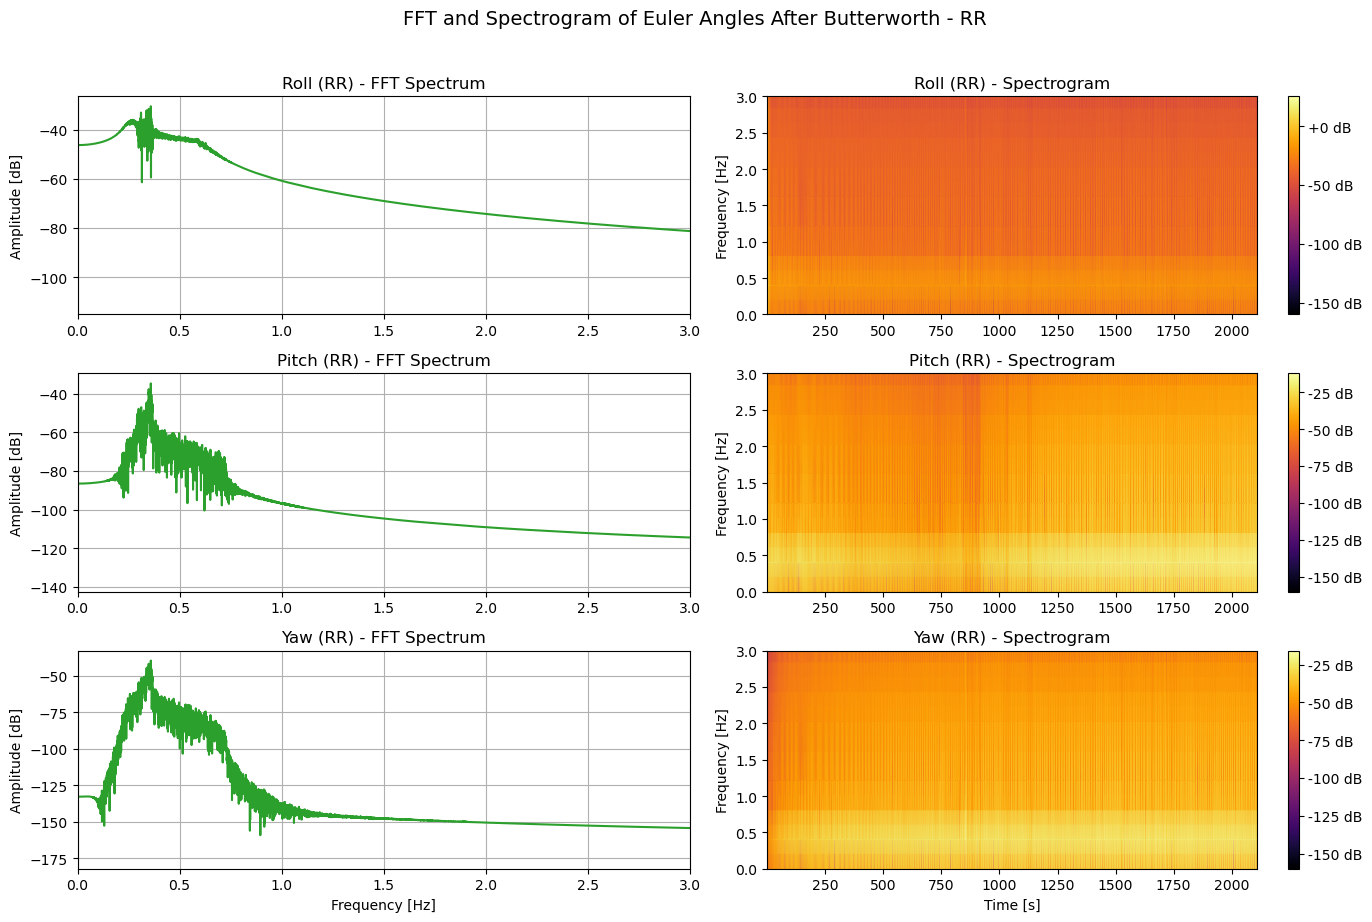

In [18]:
fs = 104  # sampling frequency
N = len(cropped_df)
spacing = 1 / fs
freqs = fftfreq(N, spacing)
mask = freqs > 0

signal_keys = ['unwrapped_r_rr', 'unwrapped_p_rr', 'unwrapped_y_rr']
angle_labels = ['Roll (RR)', 'Pitch (RR)', 'Yaw (RR)']

fig, axes = plt.subplots(3, 2, figsize=(14, 9))  # 3 rows: Roll, Pitch, Yaw; 2 columns: FFT | Spectrogram

for i, (col, label) in enumerate(zip(signal_keys, angle_labels)):
    my_signal = cropped_df[col].to_numpy(dtype=float)

    # --- FFT Amplitude Spectrum ---
    X = fft(my_signal)
    mag = np.abs(X[mask]) / N
    mag_db = 20 * np.log10(mag + 1e-16)
    axes[i, 0].plot(freqs[mask], mag_db, color='tab:green')
    axes[i, 0].set_xlim(0, 3)
    axes[i, 0].set_ylabel('Amplitude [dB]')
    axes[i, 0].set_title(f'{label} - FFT Spectrum')
    axes[i, 0].grid(True)

    # --- Spectrogram ---
    f, t, Sxx = spectrogram(my_signal, fs=fs, nperseg=256, noverlap=128)
    Sxx_db = 10 * np.log10(Sxx + 1e-16)
    im = axes[i, 1].pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='inferno')
    axes[i, 1].set_ylim(0, 3)
    axes[i, 1].set_title(f'{label} - Spectrogram')
    axes[i, 1].set_ylabel('Frequency [Hz]')
    fig.colorbar(im, ax=axes[i, 1], format='%+2.0f dB')

# Shared X-axis labels
axes[-1, 0].set_xlabel('Frequency [Hz]')
axes[-1, 1].set_xlabel('Time [s]')

plt.suptitle('FFT and Spectrogram of Euler Angles After Butterworth - RR', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

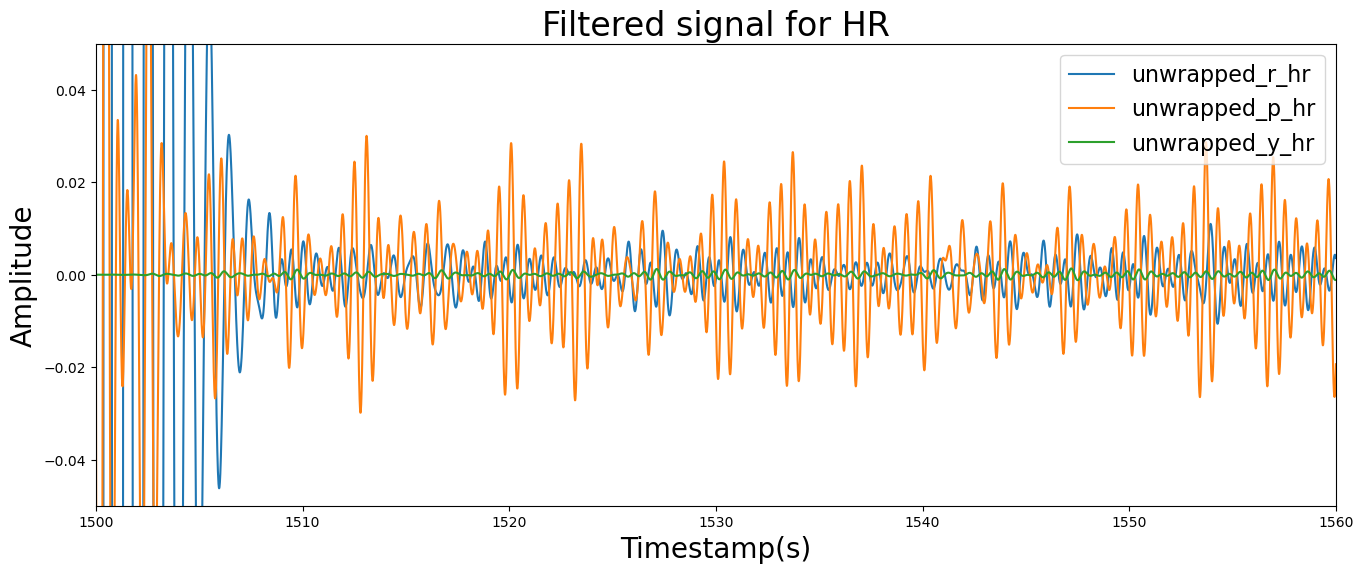

In [19]:
## Plot Predicted Data

data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_r_hr", "unwrapped_p_hr", "unwrapped_y_hr"])
data_plot_G.plot(x="Seconds", y=["unwrapped_r_hr", "unwrapped_p_hr", "unwrapped_y_hr"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Amplitude', fontsize="20")
plt.title("Filtered signal for HR", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.xlim(global_interval)
plt.ylim(-0.05,0.05)
plt.show()

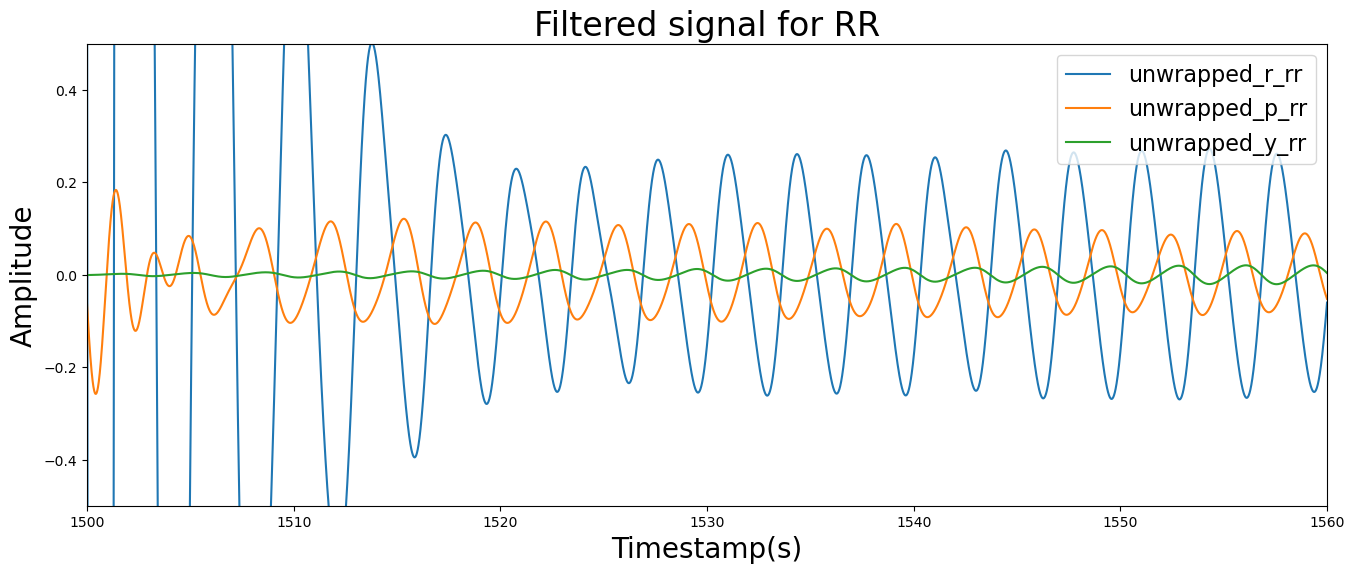

In [20]:
data_plot_G = pd.DataFrame(cropped_df, columns=["Seconds", "unwrapped_r_rr", "unwrapped_p_rr", "unwrapped_y_rr"])
data_plot_G.plot(x="Seconds", y=["unwrapped_r_rr", "unwrapped_p_rr", "unwrapped_y_rr"], figsize=(16, 6))
plt.xlabel('Timestamp(s)', fontsize="20")
plt.ylabel('Amplitude', fontsize="20")
plt.title("Filtered signal for RR", fontsize="24")
plt.legend(fontsize="16", loc ="upper right")
plt.xlim(global_interval)
plt.ylim(-0.5,0.5)
plt.show()

In [21]:
def getSTD(timeseries):
    """
    Method to get mean pressure over considered timeframe.

    :param timeseries: (Array) Array containing pressure data from a given time interval (day/stresstest/etc.) for one specific pressure (ABP/ICP/etc.).
    :return: (float) Standard deviation of pressure data.
    """
    return timeseries.std()

In [22]:
# Define interval #
start = 1500
end = 3600
interval = cropped_df.loc[(cropped_df['Seconds'] >= start) & (cropped_df['Seconds'] <= end)] # interval is a DataFrame
dur = end - start
# Adjust #
w = 100 # in amount of points (try 208 samplesa larger window (1040) and increment in between)

rr_w = 312  # samples
hr_w = 104  # samples

rr_factor = 1
hr_factor = 0.5



In [23]:
def peak_detection(df, signal_column, time_column,
                   w, std_factor, fs):
    """
    Detect peaks and valleys in `signal_column` of DataFrame `df`.
    
    Parameters
    ----------
    df : pd.DataFrame
    signal_column : str
        Name of the column containing the signal to peak-detect.
    time_column : str
        Name of the column containing time stamps (in seconds).
    w : int
        Window size (in samples) for the moving average / noise threshold.
    std_factor : float
        Multiplier for std(moving average) to define upper/lower thresholds.
    method : {'peak_to_peak_dis', 'widths'}
        How to filter by width: by inter-peak distance or by prominence widths.
    lowcut, highcut : float
        Lower/upper cutoff frequencies (in Hz) for valid peaks.
    fs : float
        Sampling frequency (in Hz), only used when `method=='widths'`.
    
    Returns
    -------
    dict with keys:
      window_df       cropped DataFrame after trimming w/2 at each end  
      time_arr        np.ndarray of times  
      sig_arr         np.ndarray of signal values  
      mov_avg         np.ndarray of moving average  
      upper_thresh    np.ndarray of upper threshold  
      lower_thresh    np.ndarray of lower threshold  
      peak_idx        np.ndarray of all peak indices (into `sig_arr`)  
      valley_idx      np.ndarray of all valley indices  
      peaks_corr      np.ndarray of “valid” peak indices  
      valleys_corr    np.ndarray of “valid” valley indices  
    """
    # trim off the first and last w//2 rows
    half = w // 2
    window_df = df.iloc[half:len(df)-half].reset_index(drop=True)
    time_arr = window_df[time_column].values
    sig_arr = window_df[signal_column].values

    # moving average & thresholds
    mov_avg = np.convolve(sig_arr, np.ones(w)/w, mode='same') #mvg average is the convolution of my signal with a box kernel of length w, where each entry of the kernel is 1/w
    sigma = getSTD(mov_avg)
    upper = mov_avg + std_factor * sigma
    lower = mov_avg - std_factor * sigma

    # raw peak/valley detection
    peak_idx, _   = signal.find_peaks(sig_arr,    height=upper)
    valley_idx, _ = signal.find_peaks(-sig_arr,   height=-lower)

    return {
        'window_df':    window_df,
        'time_arr':     time_arr,
        'sig_arr':      sig_arr,
        'mov_avg':      mov_avg,
        'upper_thresh': upper,
        'lower_thresh': lower,
        'peak_idx':     peak_idx,
        'valley_idx':   valley_idx,
    }

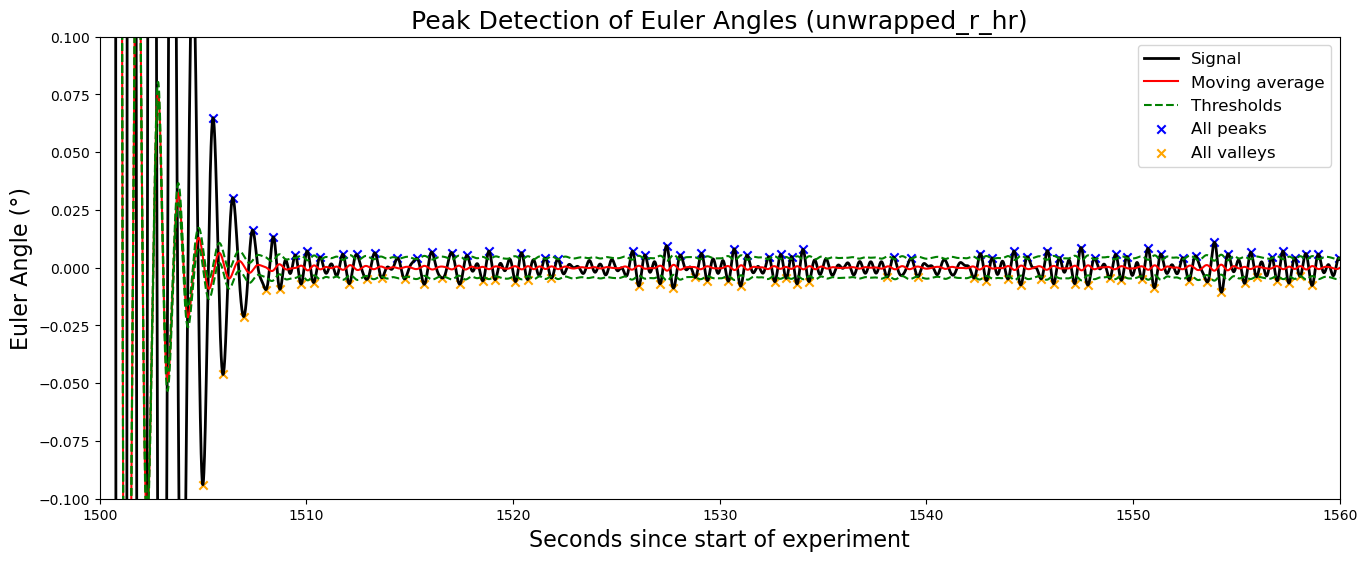

In [24]:
# Plot peak detection
col = 'unwrapped_r_hr'
res = peak_detection(
    df=cropped_df,
    signal_column=col,
    time_column='Seconds',
    w=hr_w,
    std_factor=hr_factor,
    fs=fs
)

# unpack
window      = res['window_df']
t           = res['time_arr']
y           = res['sig_arr']
mov_avg     = res['mov_avg']
upper_th    = res['upper_thresh']
lower_th    = res['lower_thresh']
all_peaks   = res['peak_idx']
all_valleys = res['valley_idx']

fig, ax = plt.subplots(figsize=(16,6))

# raw signal
ax.plot(window['Seconds'], window[col],
        color='black', linewidth=2, label='Signal')

# moving average and thresholds
ax.plot(t, mov_avg,     color='red',    label='Moving average')
ax.plot(t, upper_th,    linestyle='--', color='green', label='Thresholds')
ax.plot(t, lower_th,    linestyle='--', color='green')

# all detected peaks/valleys
ax.scatter(t[all_peaks],   y[all_peaks],   marker='x', color='blue', label='All peaks')
ax.scatter(t[all_valleys], y[all_valleys], marker='x', color='orange', label='All valleys')


# axes labels, title, limits
ax.set_xlabel('Seconds since start of experiment', fontsize=16)
ax.set_ylabel('Euler Angle (°)',                 fontsize=16)
ax.set_title(f'Peak Detection of Euler Angles ({col})', fontsize=18)

# single, clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='best')
ax.set_xlim(global_interval)
ax.set_ylim(-0.1,0.1)

ax.relim()
ax.autoscale_view()

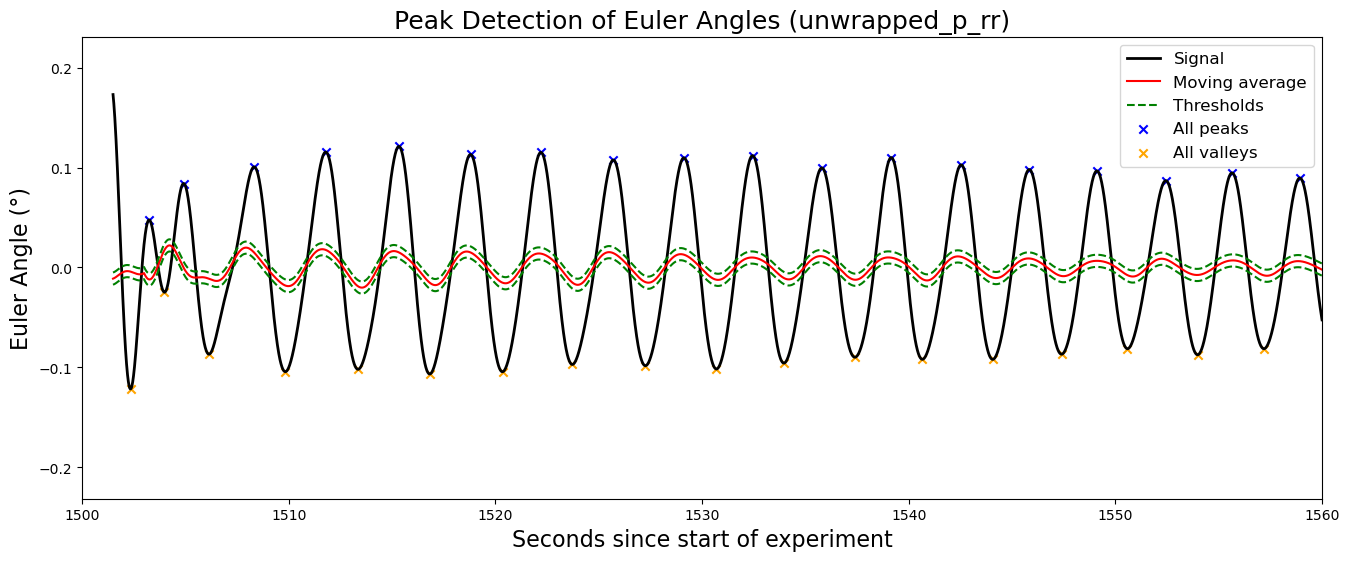

In [25]:
# Plot peak detection
col = 'unwrapped_p_rr'
res = peak_detection(
    df=cropped_df,
    signal_column=col,
    time_column='Seconds',
    w=rr_w,
    std_factor=rr_factor,
    fs=fs
)

# unpack
window      = res['window_df']
t           = res['time_arr']
y           = res['sig_arr']
mov_avg     = res['mov_avg']
upper_th    = res['upper_thresh']
lower_th    = res['lower_thresh']
all_peaks   = res['peak_idx']
all_valleys = res['valley_idx']

fig, ax = plt.subplots(figsize=(16,6))

# raw signal
ax.plot(window['Seconds'], window[col],
        color='black', linewidth=2, label='Signal')

# moving average and thresholds
ax.plot(t, mov_avg,     color='red',    label='Moving average')
ax.plot(t, upper_th,    linestyle='--', color='green', label='Thresholds')
ax.plot(t, lower_th,    linestyle='--', color='green')

# all detected peaks/valleys
ax.scatter(t[all_peaks],   y[all_peaks],   marker='x', color='blue', label='All peaks')
ax.scatter(t[all_valleys], y[all_valleys], marker='x', color='orange', label='All valleys')



# axes labels, title, limits
ax.set_xlabel('Seconds since start of experiment', fontsize=16)
ax.set_ylabel('Euler Angle (°)',                 fontsize=16)
ax.set_title(f'Peak Detection of Euler Angles ({col})', fontsize=18)
ax.set_xlim(global_interval)
# ax.set_ylim(-25, 25)

# single, clean legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=12, loc='best')
ax.relim()
ax.autoscale_view()
# plt.tight_layout()


# plt.show()

In [34]:
def compute_interval_peak_detection(
    df,
    fs,
    w,
    std_factor,
    highcut,
    lowcut,
    time_column='Seconds',
    channel_prefix='rr'  # or 'hr'
):
    """
    Computes peak detection results for a 1-minute DataFrame.
    Returns a dict with all relevant analysis info.
    """
    ch_r = f'unwrapped_r_{channel_prefix}'
    ch_p = f'unwrapped_p_{channel_prefix}'
    ch_y = f'unwrapped_y_{channel_prefix}'

    f_r, Pxx_den_r = signal.welch(df[ch_r])
    f_p, Pxx_den_p = signal.welch(df[ch_p])
    f_y, Pxx_den_y = signal.welch(df[ch_y])

    # Pxx_den_r = np.mean(abs(df[ch_r]))
    # Pxx_den_p = np.mean(abs(df[ch_p]))
    # Pxx_den_y = np.mean(abs(df[ch_y]))

    max_power_map = {
        max(Pxx_den_r): ch_r,
        max(Pxx_den_p): ch_p,
        max(Pxx_den_y): ch_y
    }
    signal_col = max_power_map[max(max_power_map)]
    axis_used = signal_col.split('_')[1]

    res = peak_detection(
        df=df,
        signal_column=signal_col,
        time_column=time_column,
        w=w,
        std_factor=std_factor,
        fs=fs
    )

    t = res['time_arr']
    valley_idx = res['valley_idx']
    valley_times = t[valley_idx]

    peak_idx = res['peak_idx']
    peak_times = t[peak_idx]
    widths_p = np.diff(peak_times)
    keep_mask = (widths_p > 1/highcut) & (widths_p < 1/lowcut)
    est = 60/np.mean(widths_p[keep_mask])

    return {
        "interval_start": df[time_column].iloc[0],
        "window_df": res['window_df'],
        "time_arr": t,
        "sig_arr": res['sig_arr'],
        "mov_avg": res['mov_avg'],
        "upper_th": res['upper_thresh'],
        "lower_th": res['lower_thresh'],
        "peak_idx": res['peak_idx'],
        "valley_idx": valley_idx,
        "keep_mask": keep_mask,
        "signal_col": signal_col,
        "axis_used": axis_used,
        "est": est,
        "max_power_map": max_power_map
    }


def plot_peak_detection_interval_info(info):
    t = info['time_arr']
    y = info['sig_arr']
    valley_idx = info['valley_idx']
    peak_idx = info['peak_idx']
    keep_mask = info['keep_mask']
    axis_used = info['axis_used']
    col = info['signal_col']
    window = info['window_df']
    start_sec = info['interval_start']

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(window['Seconds'], window[col], color='black', linewidth=2, label='Signal')
    ax.plot(t, info['mov_avg'], color='red', label='Moving average')
    ax.plot(t, info['upper_th'], '--', color='green', label='Thresholds')
    ax.plot(t, info['lower_th'], '--', color='green')
    ax.scatter(t[peak_idx], y[peak_idx], marker='x', color='blue', label='All peaks')
    ax.scatter(t[valley_idx], y[valley_idx], marker='x', color='orange', label='All valleys')

    for i in range(len(keep_mask)):
        if keep_mask[i]:
            idx1, idx2 = peak_idx[i], peak_idx[i+1]
            t1, t2 = t[idx1], t[idx2]
            y1, y2 = y[idx1], y[idx2]
            mid_t, mid_y = (t1 + t2)/2, (y1 + y2)/2
            ax.annotate('', xy=(t2, y2), xytext=(t1, y1),
                        arrowprops=dict(arrowstyle='<->', color='green', lw=2))
            ax.text(mid_t, mid_y, f"{(t2 - t1):.2f}s", color='green',
                    ha='center', va='bottom', fontsize=9)

    ax.set_title(f"Interval starting at {start_sec}s | Axis used: '{axis_used}'", fontsize=16)
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Signal")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [35]:
# peaks

In [36]:
# Define interval #
start = 0
end = 3900
interval = cropped_df.loc[(cropped_df['Seconds'] >= start) & (cropped_df['Seconds'] <= end)]
dur = end - start
hr_pm = []
rr_pm = []

rr_w = 312  # samples
hr_w = 104  # samples

rr_factor = 1
hr_factor = 0.5

interval_results_rr = []  # store all 1-min analysis
interval_results_hr = []
for _, g in interval.groupby(pd.Grouper(freq='1min', closed='right')):
    if g.empty:
        continue

    info_hr = compute_interval_peak_detection(
        df=g,
        fs=fs,
        w=hr_w,
        std_factor=hr_factor,
        highcut=highcut_hr,
        lowcut=lowcut_hr,
        channel_prefix='hr'  # or 'hr'
    )
    interval_results_hr.append(info_hr)
    hr_pm.append([g['Seconds'].iloc[0],info_hr['est']])
    print(f'max power map: {info_hr['axis_used']}')
    
    info_rr = compute_interval_peak_detection(
        df=g,
        fs=fs,
        w=rr_w,
        std_factor=rr_factor,
        highcut=highcut_rr,
        lowcut=lowcut_rr,
        channel_prefix='rr'  # or 'hr'
    )
    interval_results_rr.append(info_rr)
    rr_pm.append([g['Seconds'].iloc[0],info_rr['est']])
    # print(g['Seconds'][0])

df_hr_pm = pd.DataFrame(hr_pm, columns=['Seconds', 'HR'])
df_rr_pm = pd.DataFrame(rr_pm, columns=['Seconds', 'RR'])

df_pm = pd.merge(df_hr_pm, df_rr_pm, on='Seconds', how='inner')

max power map: r
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p
max power map: p


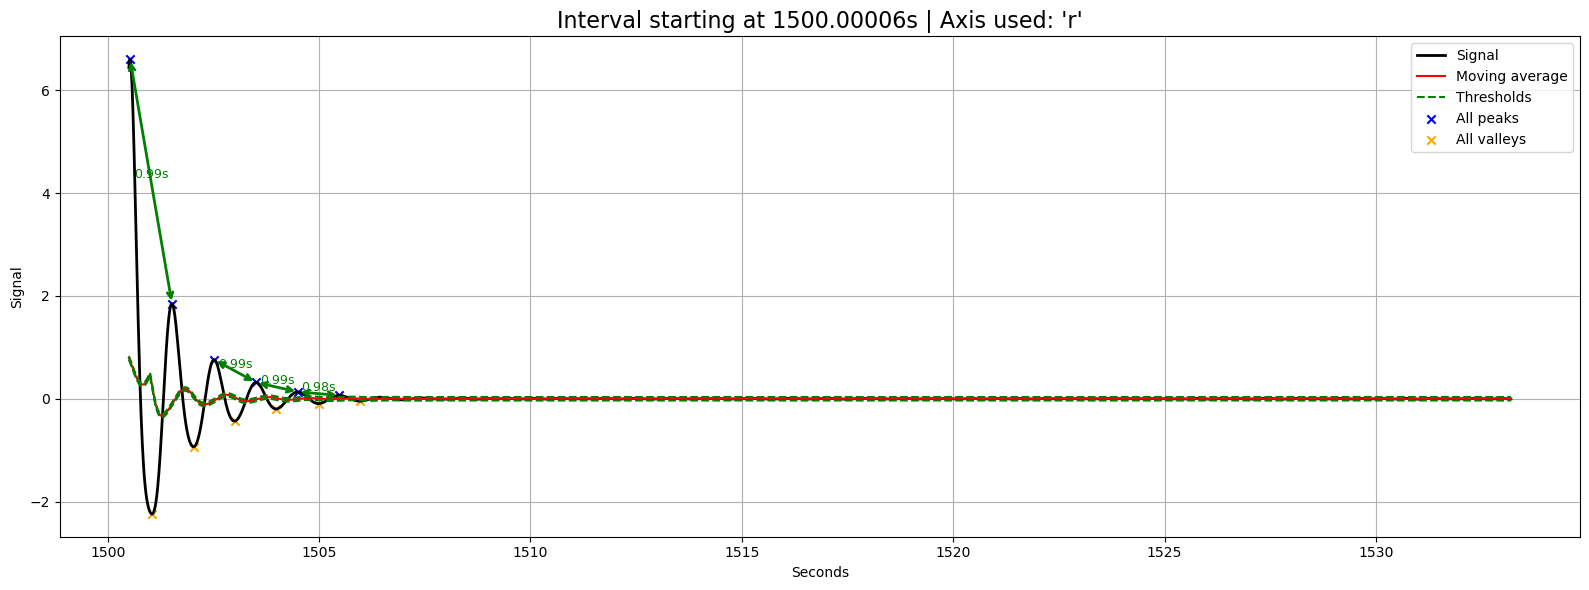

In [37]:
plot_peak_detection_interval_info(interval_results_hr[0])  # plot minute index 5

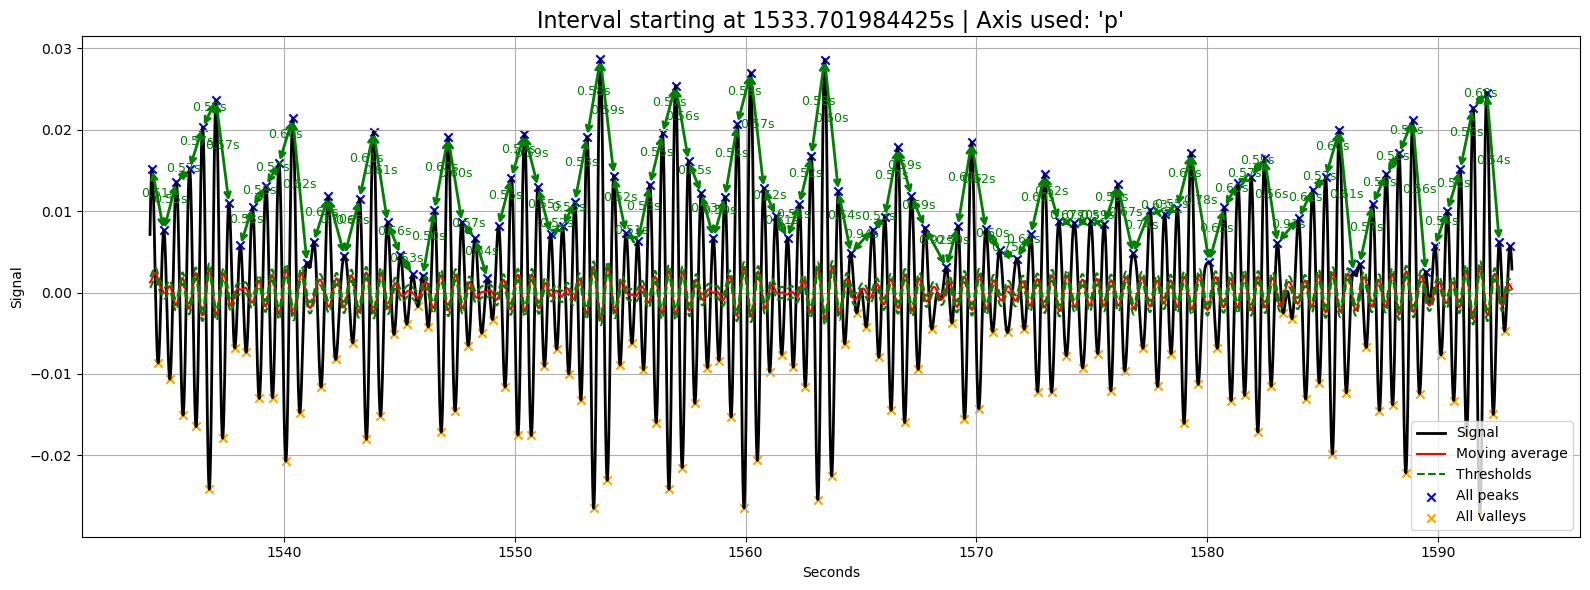

In [38]:
plot_peak_detection_interval_info(interval_results_hr[1])  # plot minute index 5

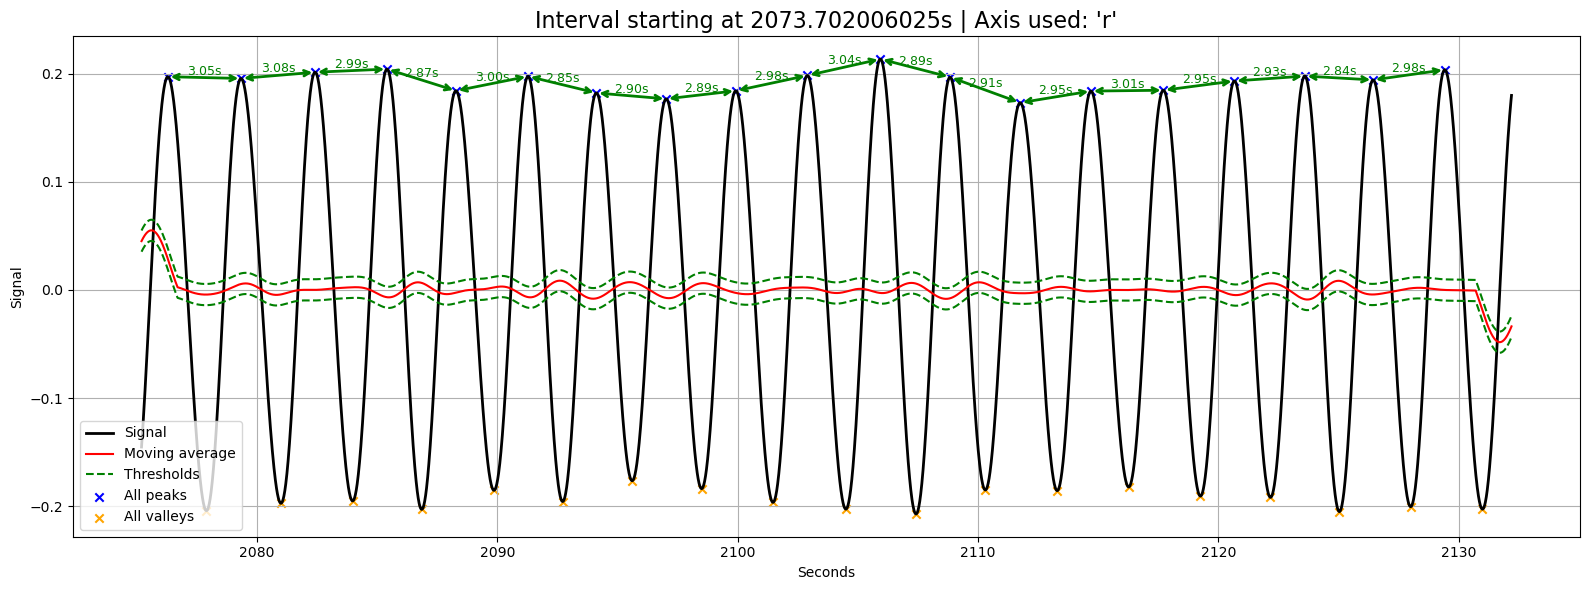

In [39]:
plot_peak_detection_interval_info(interval_results_rr[10])  # plot minute index 5

C:\Users\krisf\AppData\Local\Temp\ipykernel_9132\3302433660.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  g_data = pd.read_csv(g_file, header = header, index_col=False, dtype = 'Int64', delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])


(1500.0, 3700.0)

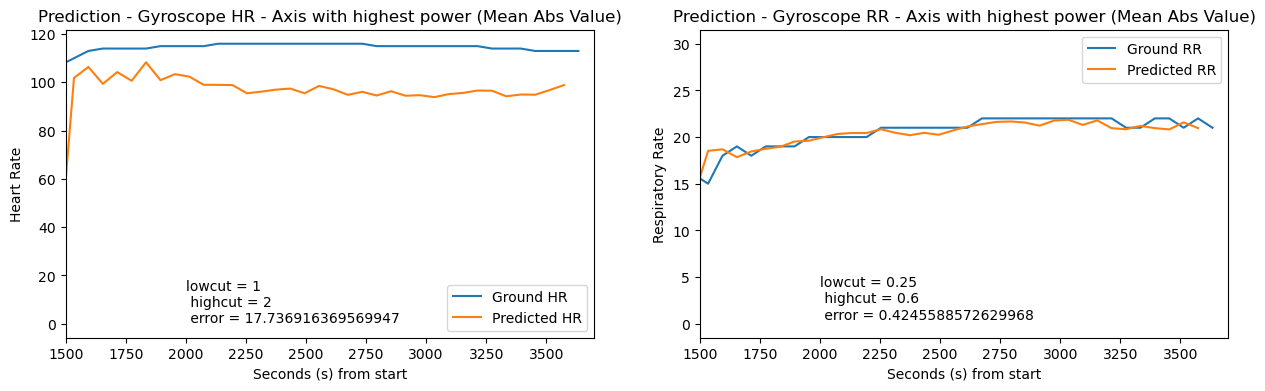

In [40]:
# Import ground data to compare:

g_file = r"C:\Users\krisf\OneDrive\Desktop\UROP SU25\Ceara sleep detection\Modified Data\ground\ground_07022025.csv"
header=0
g_data = pd.read_csv(g_file, header = header, index_col=False, dtype = 'Int64', delimiter = ',', names = ['Hour', 'Minute', 'Second','HR', 'RR'])
g_df = pd.DataFrame(g_data, columns=['Hour', 'Minute', 'Second', "HR", "RR"])

g_df["HR"] = pd.to_numeric(g_df["HR"], errors="coerce")
g_df["RR"] = pd.to_numeric(g_df["RR"], errors="coerce")

times = g_df[['Hour','Minute','Second']].astype(str).agg(':'.join, axis=1)

g_df['Time'] = pd.to_datetime('07022025'+' '+times+'.000', format='%m%d%Y %H:%M:%S.%f')

g_df = g_df.drop(['Hour','Minute','Second'], axis=1)

delta = g_df['Time'] - study_time
g_df['Seconds'] = delta.dt.total_seconds()
g_df['Seconds'] = pd.to_numeric(g_df['Seconds'], errors="coerce")


g_df_interval = g_df[g_df['Seconds']>1500]
abs_errors_hr = abs(g_df_interval['HR'].values-df_pm['HR'].values)
mean_error_hr = np.mean(abs_errors_hr)


g_df_interval = g_df[g_df['Seconds'] > 1500]
abs_errors_rr = np.abs(g_df_interval['RR'].values - df_pm['RR'].values)
mean_error_rr = np.mean(abs_errors_rr)




fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax1.plot(g_df['Seconds'], g_df['HR'], label='Ground HR')
ax1.plot(df_pm['Seconds'], df_pm['HR'], label='Predicted HR')
ax1.set_xlabel('Seconds (s) from start')
ax1.set_ylabel('Heart Rate')
ax1.set_title('Prediction - Gyroscope HR - Axis with highest power (Mean Abs Value)')
ax1.text(2000,0.5,f'lowcut = {lowcut_hr} \n highcut = {highcut_hr} \n error = {mean_error_hr}')
ax1.legend()
ax1.set_xlim(1500,3700)

g_data

ax2.plot(g_df['Seconds'], g_df['RR'], label='Ground RR')
ax2.plot(df_pm['Seconds'], df_pm['RR'], label='Predicted RR')
ax2.set_xlabel('Seconds (s) from start')
ax2.set_ylabel('Respiratory Rate')
ax2.set_title('Prediction - Gyroscope RR - Axis with highest power (Mean Abs Value)')
ax2.text(2000,0.5,f'lowcut = {lowcut_rr} \n highcut = {highcut_rr} \n error = {mean_error_rr}')
ax2.legend()
plt.xlim(1500,3700)